# Initialisation

## Installing necessary components

In [21]:
!pip install transformers
!pip install datasets
!pip install osfclient
!pip install sentencepiece
!pip install simpletransformers
from simpletransformers.classification import MultiLabelClassificationModel
# !git clone https://github.com/yjthay/DZ_GenresAndStyle.git
import csv
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import itertools
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
import string
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import re

from datasets import load_dataset, list_datasets
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer,RobertaModel, RobertaTokenizer

nltk.download('stopwords')
!wget https://raw.githubusercontent.com/yjthay/DZ_GenresAndStyle/master/utils.py
!wget https://raw.githubusercontent.com/yjthay/DZ_GenresAndStyle/master/data/ekman_mapping.json -P ./data/
!wget https://raw.githubusercontent.com/yjthay/DZ_GenresAndStyle/master/data/sentiment_mapping.json -P ./data/
# %cd /content/DZ_GenresAndStyle/

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
--2021-09-03 14:55:14--  https://raw.githubusercontent.com/yjthay/DZ_GenresAndStyle/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25279 (25K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]  24.69K  --.-KB/s    in 0s      

2021-09-03 14:55:14 (64.1 MB/s) - ‘utils.py.1’ saved [25279/25279]

--2021-09-03 14:55:14--  https://raw.githubusercontent.com/yjthay/DZ_GenresAndStyle/master/data/ekman_mapping.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.co

In [22]:
!osf -p cku2b clone /content/

0files [00:04, ?files/s]


## Utility functions

In [23]:
from utils import *

## Load full dataset

In [24]:
data = load_dataset('go_emotions')

No config specified, defaulting to: go_emotions/simplified
Reusing dataset go_emotions (/root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


## Analysis of labels

Total number of train, test and validation samples is 54263
Number of samples with 1 label/labels = 45446
Number of samples with 2 label/labels = 8124
Number of samples with 3 label/labels = 655
Number of samples with 4 label/labels = 37
Number of samples with 5 label/labels = 1


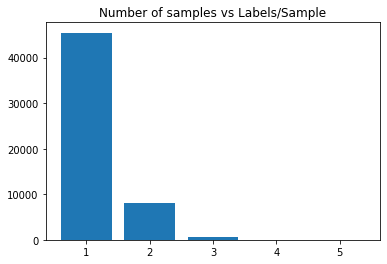

In [25]:
data_labels_all = data['train']['labels'] + data['test']['labels'] + data['validation']['labels']
print("Total number of train, test and validation samples is {}".format(len(data_labels_all)))
_labels, _counts = np.unique([len(y) for y in data_labels_all], return_counts=True)
plt.bar(_labels, _counts, align='center')
plt.gca().set_xticks(_labels)
[print("Number of samples with {} label/labels = {}".format(i, j)) for i, j in zip(_labels, _counts)]
plt.title("Number of samples vs Labels/Sample")
plt.show()

In [26]:
label_mapping = {}
label_names = data['train'].features['labels'].__dict__['feature'].names
for i, emotion in enumerate(label_names):
    label_mapping[i] = emotion.strip()
label_mapping

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral'}

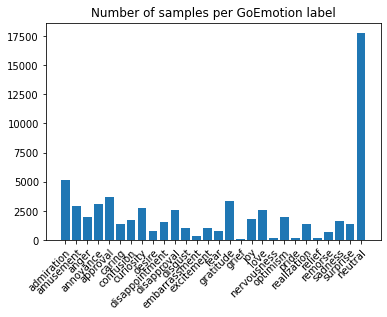

In [27]:
all_labels = list(itertools.chain.from_iterable(data_labels_all))
_labels, _counts = np.unique(all_labels, return_counts=True)
fig, ax = plt.subplots()
fig = plt.bar(_labels, _counts, align='center')
plt.gca().set_xticks(_labels)
ax.set_xticklabels(label_names, horizontalalignment='right', wrap=True, rotation=45)
plt.title("Number of samples per GoEmotion label")
plt.show()

## Analysis of text

In [28]:
data_text_all = data['train']['text'] + data['test']['text'] + data['validation']['text']
BERT_TYPE_LIST = ['bert-base-cased', 'roberta-base']
bert_type = 'bert-base-cased'
[print(i) for i in data_text_all[:5]]
tokenizer = BertTokenizer.from_pretrained(bert_type)
tokens = tokenizer(data_text_all, padding='max_length', truncation=True, max_length=60, return_tensors="pt")
# tokens = tokenizer(data_text_all, padding=True, return_tensors="pt")

My favourite food is anything I didn't have to cook myself.
Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
WHY THE FUCK IS BAYLESS ISOING
To make her feel threatened
Dirty Southern Wankers


(array([ 5695., 11332., 12211.,  9291.,  8948.,  5198.,  1143.,   317.,
           77.,    51.]),
 array([ 3. ,  8.7, 14.4, 20.1, 25.8, 31.5, 37.2, 42.9, 48.6, 54.3, 60. ]),
 <a list of 10 Patch objects>)

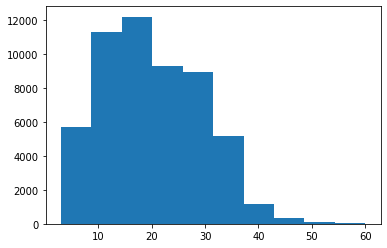

In [29]:
from scipy import stats

max_len = 0
total = 0
a = [sum(i != 0).item() for i in tokens['input_ids']]
plt.hist(a)

In [30]:
for input, att in zip(tokens['input_ids'], tokens['attention_mask']):
    if sum(att) >= 64:
        print(sum(att))
        print(tokenizer.decode(input))

In [31]:
from nltk.corpus import stopwords

data_text_all = data['train']['text'] + data['test']['text'] + data['validation']['text']
data_labels_all = data['train']['labels'] + data['test']['labels'] + data['validation']['labels']
stop = stopwords.words('english')
stop.append('')
stop.append('[name]')

In [32]:
porter = PorterStemmer()
sentences = [sentence.split(" ") for sentence in data_text_all]
sentence_word = []

# Remove stop words and create a list of list of the stemmed words
for sentence in sentences:
    sentence_word.append([porter.stem(w) for w in sentence if w.lower() not in stop])

# Allocated stemmed words to the specific labels we see them
words_of_label = {}
for idx, multilabel in enumerate(data_labels_all):
    for label in multilabel:
        if label not in words_of_label.keys():
            words_of_label[label] = sentence_word[idx]
        else:
            words_of_label[label] += sentence_word[idx]

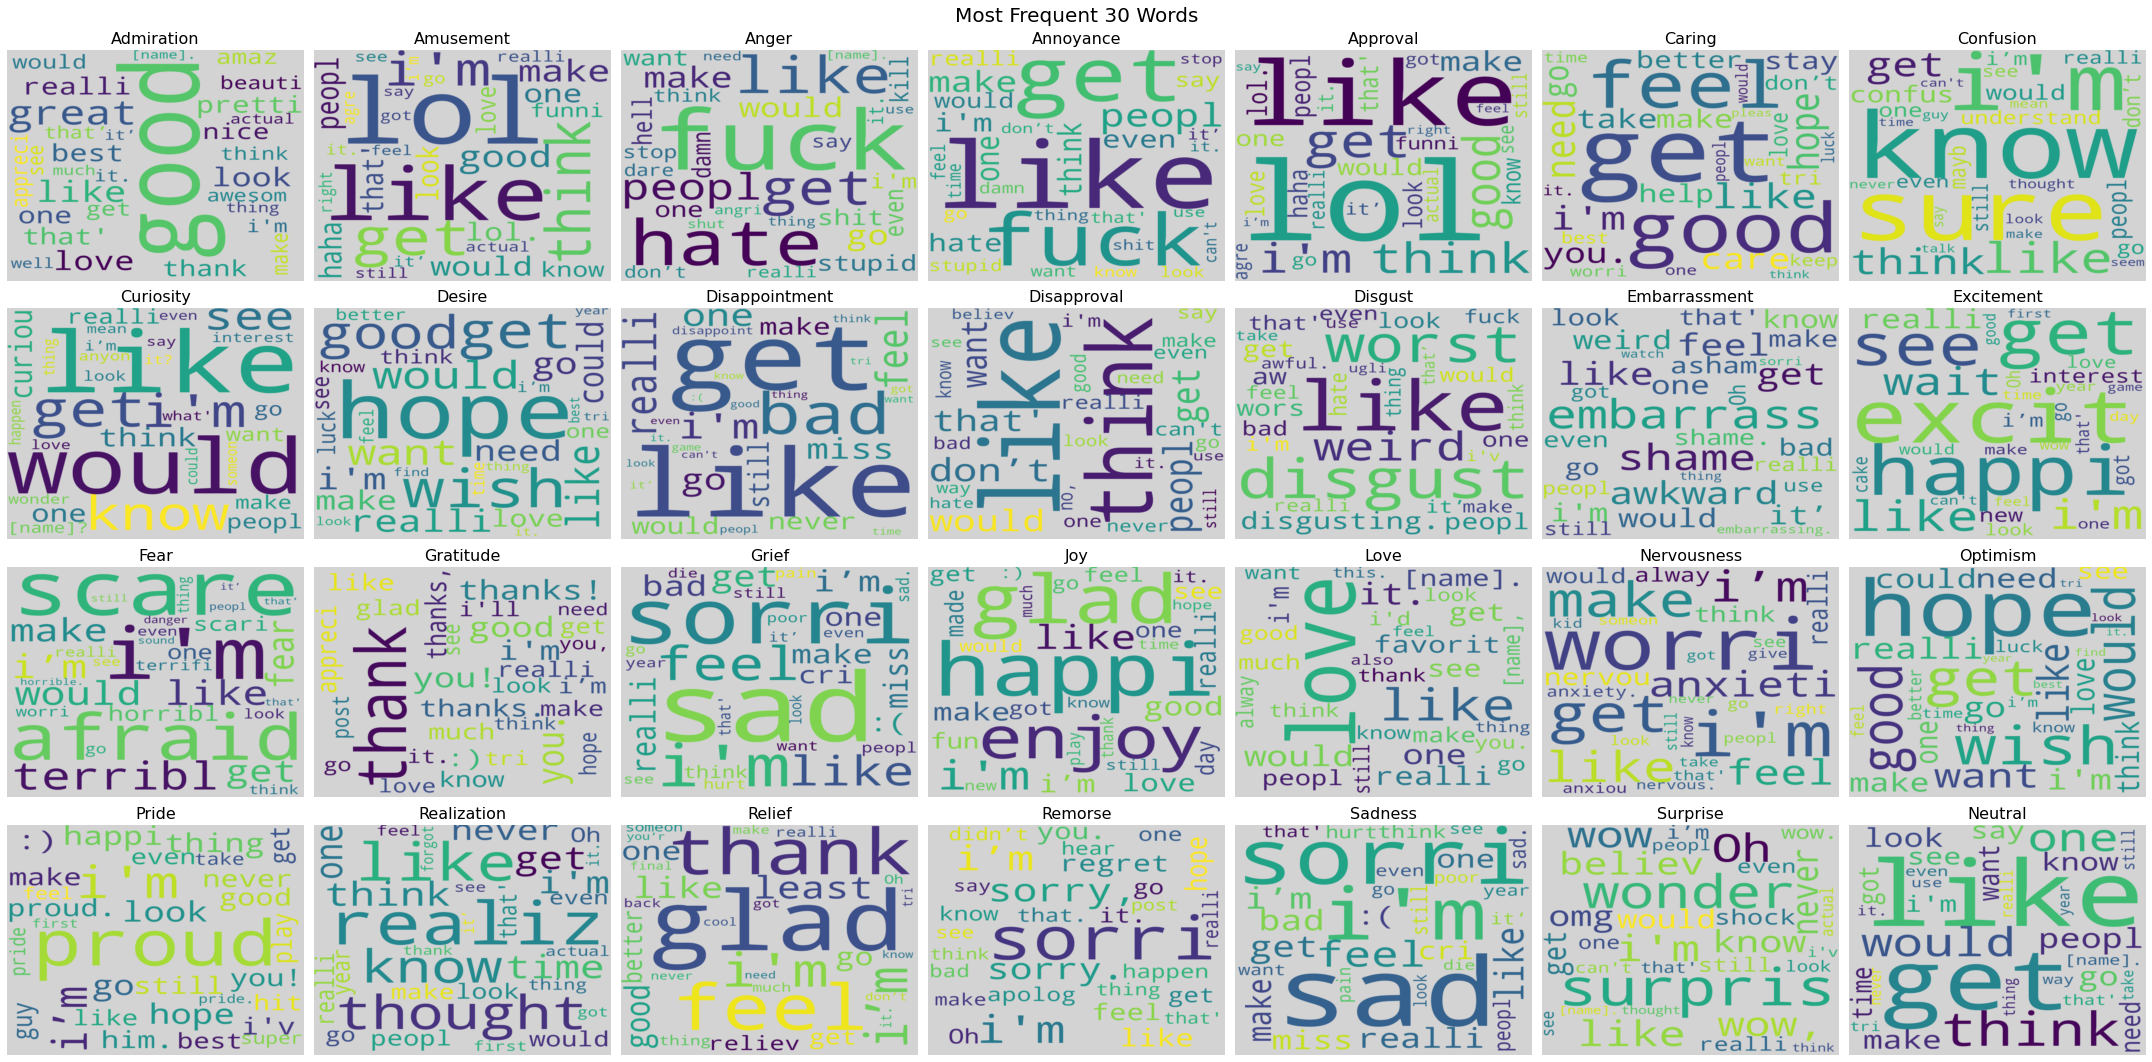

In [33]:
f = plt.figure(figsize=(30,15))
f.suptitle("Most Frequent 30 Words",fontsize=20)
for i in range(28):
    wordCloud = WordCloud(max_words=30, width=800, height=800, background_color='lightgrey')
    wordCloud.generate_from_frequencies(nltk.FreqDist(words_of_label[i]))

    ax = f.add_subplot(4,7, i+1)
    ax.set_title(label_mapping[i].capitalize(),fontsize=16)
    ax.imshow(wordCloud, interpolation='bilinear', aspect="auto")
    ax.axis("off")
f.tight_layout()
f.subplots_adjust(top=0.94)

# Training

In [37]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

pre_path='/content/drive/MyDrive/DeepZen/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Training model for various BERTs

In [ ]:
# BERT_TYPE_LIST = ['bert-base-cased','bert-base-uncased','distilbert-base-cased', 'roberta-large','roberta-base','distilroberta-base']
DEVICE = 'cuda'  # cuda or cpu
save_path = pre_path+'model/epochs/'
max_length=64

for BERT_TYPE in ['distilbert-base-cased', 'bert-base-cased']:
    print(BERT_TYPE)
    train_dataset = EmotionsDataset(data['train'], device=DEVICE, bert_type=BERT_TYPE, max_length=max_length)
    val_dataset = EmotionsDataset(data['validation'], device=DEVICE, bert_type=BERT_TYPE, max_length=max_length)
    model = BERT_Model((max_length * 768, 28), BERT_TYPE, device=DEVICE) #(input dim, hidden dim, output dim)
    train_losses, val_losses = train(model, train_dataset, val_dataset, epochs=4, lr=2e-5, batch_size=16, show_progress=True, save_path=save_path+BERT_TYPE+"/")

## T5 Training

In [ ]:
data = load_dataset('go_emotions')
val_data = T5Dataset(data['validation'], goemo_ratio=1.0)
DEVICE = 'cuda'  # cuda or cpu

for ratio in [1.0,0.75,0.5,0.333]:
    # save_path = '/content/drive/MyDrive/DeepZen/model/epochs/t5-base/'
    # model_file_path = best_model_filename(pre_path+str(ratio)+'/')
    # tuned_model = torch.load(model_file_path, map_location=torch.device(DEVICE))
    model = T5Model().to(DEVICE)
    train_losses, val_losses = train_T5(model, data, goemo_ratio=ratio, epochs=20, lr=2e-5, batch_size=16, show_progress=True, save_path=save_path+"/"+str(ratio)+"/")

## Duplicating files into osf storage from Google Drive

In [ ]:
!osf init
!osf list
!osf -p cku2b upload -r /content/drive/MyDrive/DeepZen/model/epochs /model/

# Analysis of results

Loading the best model based on the validation error

In [49]:
model_names = ['distilbert-base-cased', 'bert-base-cased', 'roberta-base']#,'t5-base']
DEVICE = 'cuda' #'cpu'
# pre_path = 'osfstorage/model/epochs/'
pre_path = '/content/drive/MyDrive/DeepZen/model/epochs/'
tuned_models = {}
for name in model_names:
    architecture = re.findall("^(.*?)-",name)[0]
    tuned_models[name] = MultiLabelClassificationModel(architecture, pre_path+"/"+name+"/outputs/best_model")
print(tuned_models.keys())

dict_keys(['distilbert-base-cased', 'bert-base-cased', 'roberta-base'])


## F1 Score of Models (Testing)

In [69]:
from sklearn.metrics import f1_score, recall_score, precision_score, hamming_loss, accuracy_score
import pandas as pd

test_data = EmotionsDataset(data['test'], max_length=64, device=DEVICE)
t5_data_set = T5Dataset(data['test'], goemo_ratio=1.0)
threshold = 0.3
f1, f1_macro, precision, precision_macro, recall, recall_macro = {}, {}, {}, {}, {}, {}
for name in model_names:
    # y_pred_test = predict(torch.load('/content/drive/MyDrive/DeepZen/model/epochs/roberta-base/epoch_2_0.15042.pt', map_location=torch.device(DEVICE)), test_data)
    _, y_pred_test = tuned_models[name].predict(test_data.text)
    architecture = re.findall("^(.*?)-",name)[0]
    y_true_test = test_data.labels.cpu().numpy()
    y_pred_test = (y_pred_test>=threshold) * np.ones(y_pred_test.shape)
    f1[architecture] = np.hstack((f1_score(y_true_test, y_pred_test, average=None),
                          f1_score(y_true_test, y_pred_test, average='macro'),
                          hamming_loss(y_true_test, y_pred_test),
                          accuracy_score(y_true_test, y_pred_test)))
    precision[architecture] = np.hstack((precision_score(y_true_test, y_pred_test, average=None),
                                 precision_score(y_true_test, y_pred_test, average='macro')))
    recall[architecture] = np.hstack((recall_score(y_true_test, y_pred_test, average=None),
                              recall_score(y_true_test, y_pred_test, average='macro')))
    hl = hamming_loss(y_true_test, y_pred_test)
    a = accuracy_score(y_true_test, y_pred_test)
    print("Name: {} yields an Hamming Loss of {} and Accuracy of {}".format(name, hl, a))

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Name: distilbert-base-cased yields an Hamming Loss of 0.03288451920292716 and Accuracy of 0.46379215035931454


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Name: bert-base-cased yields an Hamming Loss of 0.03448366632446234 and Accuracy of 0.44481297217615623


  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Name: roberta-base yields an Hamming Loss of 0.03348337676695886 and Accuracy of 0.4536576377372397


In [70]:
# pre_path = '/content/drive/MyDrive/DeepZen/model/epochs'
for dir,folders,files in os.walk(pre_path):
    if dir==pre_path:
        for f in files:
            fname = dir+'/'+f
            name = 't5-'+re.findall('_(.+)_',f)[0]
            y_pred_test = predict_t5(torch.load(fname, map_location=torch.device(DEVICE)), t5_data_set)
            y_true_test =  test_data.labels.cpu().numpy()
            f1[name] = np.hstack((f1_score(y_true_test, y_pred_test, average=None),
                                  f1_score(y_true_test, y_pred_test, average='macro'),
                                  hamming_loss(y_true_test, y_pred_test),
                                  accuracy_score(y_true_test, y_pred_test)))
            precision[name] = np.hstack((precision_score(y_true_test, y_pred_test, average=None),
                                        precision_score(y_true_test, y_pred_test, average='macro')))
            recall[name] = np.hstack((recall_score(y_true_test, y_pred_test, average=None),
                                     recall_score(y_true_test, y_pred_test, average='macro')))
            hl = hamming_loss(y_true_test, y_pred_test)
            a = accuracy_score(y_true_test, y_pred_test)
            print("Name: {} yields an Hamming Loss of {} and Accuracy of {}".format(f, hl, a))

Name: ratio_1.0_0.25298.pt yields an Hamming Loss of 0.03181842112190371 and Accuracy of 0.5245992260917635
Name: ratio_0.75_0.25555.pt yields an Hamming Loss of 0.03123272526257601 and Accuracy of 0.5330753639211351
Name: ratio_0.5_0.25995.pt yields an Hamming Loss of 0.031324857195503965 and Accuracy of 0.5306799336650083
Printing unrecognized word in GoEmotions mapping: ['goemo', 'worry']
Name: ratio_0.333_0.26463.pt yields an Hamming Loss of 0.03187106794071968 and Accuracy of 0.5223880597014925


In [71]:
# Create Index for f1, precision and recall tables
vals = list(config.GOEMO_MAPPING.values())
p_r_index = np.hstack((vals,
                      'macro'))
f1_index = np.hstack((p_r_index,'hamming loss','accuracy'))
p_r_index,f1_index

(array(['admiration', 'amusement', 'anger', 'annoyance', 'approval',
        'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
        'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
        'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
        'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise',
        'neutral', 'macro'], dtype='<U14'),
 array(['admiration', 'amusement', 'anger', 'annoyance', 'approval',
        'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
        'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
        'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
        'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise',
        'neutral', 'macro', 'hamming loss', 'accuracy'], dtype='<U14'))

In [72]:
pd.set_option('precision', 4)
f1_emotions = pd.DataFrame(f1, index=f1_index)
precision_emotions = pd.DataFrame(precision, index=p_r_index)
recall_emotions = pd.DataFrame(recall, index=p_r_index)

In [73]:
f1_emotions#.loc['macro']

,distilbert,bert,roberta,t5-1.0,t5-0.75,t5-0.5,t5-0.333
admiration,0.7044,0.6895,0.6917,0.7060,0.6968,0.7082,0.6945
amusement,0.8265,0.8185,0.8311,0.8268,0.8175,0.8225,0.8241
anger,0.4550,0.4899,0.4964,0.4764,0.4509,0.4800,0.4432
annoyance,0.3800,0.3898,0.3820,0.2770,0.3135,0.2265,0.2985
approval,0.4060,0.4373,0.4151,0.4168,0.4065,0.4100,0.3743
caring,0.3967,0.4523,0.4337,0.4321,0.4820,0.4337,0.4249
confusion,0.4730,0.4481,0.4510,0.4333,0.4373,0.4160,0.4308
curiosity,0.5423,0.5801,0.5938,0.5402,0.5167,0.5212,0.5357
desire,0.4531,0.4476,0.5352,0.5147,0.4848,0.4853,0.5067
disappointment,0.3005,0.2932,0.2667,0.3333,0.2584,0.3154,0.2797


In [ ]:
precision_emotions

In [ ]:
recall_emotions


## F1 Score of Testing Set

In [ ]:
test_data = EmotionsDataset(data['test'], max_length=64, device=DEVICE)
y_pred_test = predict(model, test_data)
y_true_test =  test_data.labels.cpu().numpy()

for i in range(1,10):
    threshold = i/10.
    y_pred = (y_pred_test>=threshold) * np.ones(y_pred_test.shape)
    f1 = f1_score(y_true_test, y_pred, average='samples')
    print("Testing - Sigmoid Threshold of {} yields an f1 score of {}".format(threshold, f1))

### tSNE Plot of GoEmotions - Test

In [ ]:
# Ignoring neutral
visualize_scatter(gen_tsne_values(y_pred_test[:,:-1]), y_true_test[:,:-1], label_mapping)

### tSNE Plot of Ekman - Test

In [ ]:
y_true_test_ekman = convert_to_ekman(reverse_one_hot(y_true_test))
y_true_test_ekman = label_multi_one_hot(y_true_test_ekman).numpy()
ekman_fname='data/ekman_mapping.json'
with open(ekman_fname) as f:
    ekman_mapping = json.load(f)
ekman_label_mapping = {}
for idx, key in enumerate(ekman_mapping):
    ekman_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_test[:,:-1]), y_true_test_ekman[:,:-1], ekman_label_mapping)

### tSNE Plot of Sentiment - Test

In [ ]:
y_true_test_sentiment = convert_to_sentiment(reverse_one_hot(y_true_test))
y_true_test_sentiment = label_multi_one_hot(y_true_test_sentiment).numpy()
sentiment_fname='data/sentiment_mapping.json'
with open(sentiment_fname) as f:
    sentiment_mapping = json.load(f)
sentiment_label_mapping = {}
for idx, key in enumerate(sentiment_mapping):
    sentiment_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_test[:,:-1]), y_true_test_sentiment[:,:-1], sentiment_label_mapping)

## F1 Score of Validation Set

In [ ]:
val_data = EmotionsDataset(data['validation'], max_length=64, device=DEVICE)
y_pred_val = predict(model, val_data)
y_true_val =  val_data.labels.cpu().numpy()

for i in range(1,10):
    threshold = i/10.
    y_pred = (y_pred_val>=threshold) * np.ones(y_pred_val.shape)
    f1 = f1_score(y_true_val, y_pred, average='samples')
    print("Validation - Sigmoid Threshold of {} yields an f1 score of {}".format(threshold, f1))

### tSNE Plot of GoEmotions - Validation

In [ ]:
# Ignoring neutral
visualize_scatter(gen_tsne_values(y_pred_val[:,:-1]), y_true_val[:,:-1], label_mapping)

### tSNE Plot of Ekman - Validation

In [ ]:
y_true_val_ekman = convert_to_ekman(reverse_one_hot(y_true_val))
y_true_val_ekman = label_multi_one_hot(y_true_val_ekman).numpy()
ekman_fname='data/ekman_mapping.json'
with open(ekman_fname) as f:
    ekman_mapping = json.load(f)
ekman_label_mapping = {}
for idx, key in enumerate(ekman_mapping):
    ekman_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_val[:,:-1]), y_true_val_ekman[:,:-1], ekman_label_mapping)

### tSNE Plot of Sentiment - Validation

In [ ]:
y_true_val_sentiment = convert_to_sentiment(reverse_one_hot(y_true_val))
y_true_val_sentiment = label_multi_one_hot(y_true_val_sentiment).numpy()
sentiment_fname='data/sentiment_mapping.json'
with open(sentiment_fname) as f:
    sentiment_mapping = json.load(f)
sentiment_label_mapping = {}
for idx, key in enumerate(sentiment_mapping):
    sentiment_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_val[:,:-1]), y_true_val_sentiment[:,:-1], sentiment_label_mapping)

## F1 Score of Training Set

In [ ]:
train_data = EmotionsDataset(data['train'], max_length=64, device=DEVICE)
y_pred_train = predict(model, train_data)
y_true_train =  train_data.labels.cpu().numpy()

for i in range(1,10):
    threshold = i/10.
    y_pred = (y_pred_train>=threshold) * np.ones(y_pred_train.shape)
    f1 = f1_score(y_true_train, y_pred, average='samples')
    print("Training - Sigmoid Threshold of {} yields an f1 score of {}".format(threshold, f1))

### tSNE Plot of GoEmotions - Training

In [ ]:
# Ignoring neutral
visualize_scatter(gen_tsne_values(y_pred_train[:,:-1]), y_true_train[:,:-1], label_mapping)

### tSNE Plot of Ekman - Training

In [ ]:
y_true_train_ekman = convert_to_ekman(reverse_one_hot(y_true_train))
y_true_train_ekman = label_multi_one_hot(y_true_train_ekman).numpy()
ekman_fname='data/ekman_mapping.json'
with open(ekman_fname) as f:
    ekman_mapping = json.load(f)
ekman_label_mapping = {}
for idx, key in enumerate(ekman_mapping):
    ekman_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_train[:,:-1]), y_true_train_ekman[:,:-1], ekman_label_mapping)

### tSNE Plot of Sentiment - Training

In [ ]:
y_true_train_sentiment = convert_to_sentiment(reverse_one_hot(y_true_train))
y_true_train_sentiment = label_multi_one_hot(y_true_train_sentiment).numpy()
sentiment_fname='data/sentiment_mapping.json'
with open(sentiment_fname) as f:
    sentiment_mapping = json.load(f)
sentiment_label_mapping = {}
for idx, key in enumerate(sentiment_mapping):
    sentiment_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_train[:,:-1]), y_true_train_sentiment[:,:-1], sentiment_label_mapping, figsize=(20,20))



In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

a = tokenizer.encode("translate English to French: My favourite food is anything I didn't have to cook myself",return_tensors="pt")
# a = tokenizer.encode("translate English to German: My favourite food is anything I didn't have to cook myself",return_tensors="pt")
print(a)
b = model.generate(a)
print(b)
tokenizer.decode(b[0])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

threshold = 0.3
y_pred = (y_pred_test>=threshold) * np.ones(y_pred_test.shape)
results = {}
label_mapping = mapping()
for i in range(28):
    emotion = label_mapping[i]
    emotion_true = y_true_test[:, i]
    emotion_pred = y_pred[:, i]
    # results[emotion + "_accuracy"] = accuracy_score(emotion_true, emotion_pred)
    results[emotion + "_precision"], results[emotion + "_recall"], results[emotion + "_f1"], _ = precision_recall_fscore_support(emotion_true, emotion_pred, average="binary")

# test = 0
# count = 0
for i in results:
    print(i,results[i])